In [1]:
!pip -q install scikit-learn

import os, torch, torchaudio
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [2]:
import os, math, time, json, pathlib, random
from typing import Tuple, Dict
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# =========================
# Config
# =========================
SAMPLE_RATE = 16000
DURATION_S  = 1.0   # we'll crop/pad to 1 second
N_MELS      = 128
BATCH_SIZE  = 32
EPOCHS      = 30

# Telephony augmentation toggle (baseline Task A = False)
USE_AUG = False

# dataset caps based on your requirement
REAL_MAIN_CAP  = 60000   # from combined_folder/real
REAL_WILD_CAP  = 20000   # from in-the-wild/real
# fake is ~80k from AUDETER, we take all

# Paths (edit if Kaggle mount names change)
FAKE_ROOT       = "/kaggle/input/audeter-subset-3500each-all/audeter_subset_3500each_ALL"
REAL_MAIN_ROOT  = "/kaggle/input/ready-to-input-for-training/combined_folder/real"
REAL_WILD_ROOT  = "/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset (torchaudio-only; no librosa)

In [3]:
class TelephonyAug:
    """
    Phone-like narrowband + mild distortion + light noise.
    We'll leave USE_AUG=False for Task A baseline training,
    but this will be important later for Task B continual learning.
    """
    def __init__(self, sample_rate=16000, nb_sr=8000, noise_snr_db=(10, 25)):
        self.sr = sample_rate
        self.nb_sr = nb_sr
        self.noise_snr_db = noise_snr_db

    def _add_noise(self, x: torch.Tensor):
        snr_db = float(np.random.uniform(*self.noise_snr_db))
        p_sig = x.pow(2).mean().item() + 1e-12
        p_noise = p_sig / (10 ** (snr_db / 10))
        noise = torch.randn_like(x) * math.sqrt(p_noise)
        return x + noise

    def __call__(self, wav: torch.Tensor):
        # downsample to narrowband-ish, compand, upsample, bandlimit, add noise
        y = torchaudio.functional.resample(wav, self.sr, self.nb_sr)
        y = torch.tanh(1.5 * y)
        y = torchaudio.functional.resample(y, self.nb_sr, self.sr)
        y = torchaudio.functional.highpass_biquad(y, self.sr, 300)
        y = torchaudio.functional.lowpass_biquad(y, self.sr, 3400)
        y = self._add_noise(y)
        return y


class DeepfakeAudioDatasetTaskA(Dataset):
    """
    Task A dataset:
    - Fake: all clips from AUDETER (~80k), label=1
    - Real: 60k clips from combined_folder/real, label=0
    - Real: 20k clips from in-the-wild/real, label=0
    Result: ~80k fake vs ~80k real (balanced).
    """
    def __init__(
        self,
        fake_root: str,
        real_root_main: str,
        real_root_wild: str,
        real_main_cap: int = 60000,
        real_wild_cap: int = 20000,
        sample_rate: int = 16000,
        duration: float = 1.0,
        n_mels: int = 128,
        use_aug: bool = False,
        extensions=(".wav", ".flac", ".mp3")
    ):
        self.sample_rate = sample_rate
        self.duration = duration
        self.max_len = int(sample_rate * duration)
        self.n_mels = n_mels
        self.use_aug = use_aug

        # --------------------
        # 1. Collect FAKE (label=1) from AUDETER (recursive scan)
        # --------------------
        fake_paths = []
        if os.path.isdir(fake_root):
            for root, dirs, files in os.walk(fake_root):
                for f in files:
                    if f.lower().endswith(extensions):
                        fake_paths.append(os.path.join(root, f))
        fake_labels = [1] * len(fake_paths)

        # --------------------
        # 2. Collect REAL from combined_folder/real (cap 60k)
        # --------------------
        real_paths_main = []
        if os.path.isdir(real_root_main):
            for f in os.listdir(real_root_main):
                p = os.path.join(real_root_main, f)
                if os.path.isfile(p) and f.lower().endswith(extensions):
                    real_paths_main.append(p)
        random.shuffle(real_paths_main)
        real_paths_main = real_paths_main[:real_main_cap]

        # --------------------
        # 3. Collect REAL from in-the-wild/real (cap 20k)
        # --------------------
        real_paths_wild = []
        if os.path.isdir(real_root_wild):
            for f in os.listdir(real_root_wild):
                p = os.path.join(real_root_wild, f)
                if os.path.isfile(p) and f.lower().endswith(extensions):
                    real_paths_wild.append(p)
        random.shuffle(real_paths_wild)
        real_paths_wild = real_paths_wild[:real_wild_cap]

        # --------------------
        # 4. Merge REAL pools
        # --------------------
        real_paths = real_paths_main + real_paths_wild
        real_labels = [0] * len(real_paths)

        # --------------------
        # 5. Final combined list
        # --------------------
        self.audio_paths = fake_paths + real_paths
        self.labels = fake_labels + real_labels

        print(f"[TaskA Dataset] fake={len(fake_paths)} real={len(real_paths)} total={len(self.audio_paths)}")

        # --------------------
        # 6. Feature transforms: MelSpectrogram + dB
        # --------------------
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_mels=self.n_mels,
            n_fft=1024,
            hop_length=256,
            power=2.0
        )
        self.to_db = torchaudio.transforms.AmplitudeToDB(stype="power")

        self.tel_aug = TelephonyAug(sample_rate=self.sample_rate) if self.use_aug else None

    def __len__(self):
        return len(self.audio_paths)

    def _load_resample_mono(self, path: str) -> torch.Tensor:
        wav, sr = torchaudio.load(path)  # (C, N)
        wav = wav.mean(dim=0)  # mono mixdown
        if sr != self.sample_rate:
            wav = torchaudio.functional.resample(wav, sr, self.sample_rate)

        # pad or trim to fixed length
        if wav.shape[0] < self.max_len:
            wav = F.pad(wav, (0, self.max_len - wav.shape[0]))
        else:
            wav = wav[: self.max_len]
        return wav

    def __getitem__(self, idx: int):
        path = self.audio_paths[idx]
        label = self.labels[idx]

        wav = self._load_resample_mono(path)  # shape (L,)
        if self.tel_aug is not None:
            wav = self.tel_aug(wav)

        wav_2d = wav.unsqueeze(0)  # (1, L)

        mel = self.melspec(wav_2d)  # (1, n_mels, T)
        mel_db = self.to_db(mel)

        return wav_2d.float(), mel_db.float(), torch.tensor(label).long()


Here we:

define TelephonyAug,

define DeepfakeAudioDatasetTaskA that:

loads all fake from AUDETER,

loads 60k real from combined_folder/real,

loads 20k real from in-the-wild/real,

does waveform trimming/padding,

makes Mel-spectrogram.

In [4]:
class SpecRNet(nn.Module):
    """
    CNN over Mel-spectrogram -> 128-D embedding
    """
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(64, 128)

    def forward(self, x):
        x = self.features(x)      # (B,64,1,1)
        x = x.view(x.size(0), -1) # (B,64)
        return self.fc(x)         # (B,128)


class RawGATST(nn.Module):
    """
    Lightweight 1D conv stack on raw waveform -> 128-D embedding
    """
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 128)

    def forward(self, x):
        x = self.conv(x)              # (B,128,T')
        x = self.pool(x).squeeze(-1)  # (B,128)
        return self.fc(x)             # (B,128)


class FusionNet(nn.Module):
    """
    Fuse raw branch + mel branch -> classifier (REAL vs FAKE)
    """
    def __init__(self):
        super().__init__()
        self.spec_model = SpecRNet()
        self.raw_model  = RawGATST()
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, raw_wave, mel_spec):
        raw_feat  = self.raw_model(raw_wave)    # (B,128)
        spec_feat = self.spec_model(mel_spec)   # (B,128)
        fused = torch.cat((raw_feat, spec_feat), dim=1)  # (B,256)
        return self.classifier(fused)           # (B,2)


1.	SpecRNet → CNN applied on Mel-spectrograms (2D input).
(mel_spec): a time–frequency representation, closer to how humans perceive sound, useful to detect spectral artifacts in fakes
2.	RawGAT-ST → CNN applied on raw waveforms (1D input).
(raw_wave): the direct audio signal, useful to capture fine low-level details (noise, glitches).
3.	Feature Fusion → Concatenation of both feature vectors.
---->processes two views of the same audio.


models (SpecRNet, RawGATST, FusionNet)

In [5]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()
    for raw, mel, labels in loader:
        raw, mel, labels = raw.to(device), mel.to(device), labels.to(device)
        outputs = model(raw, mel)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / max(1, total), correct / max(1, total)


def count_params(model: nn.Module):
    return sum(p.numel() for p in model.parameters())


def file_size_mb(path: str) -> float:
    p = pathlib.Path(path)
    return p.stat().st_size / (1024 * 1024)


def benchmark_inference(model, loader, device=torch.device("cpu")):
    model = model.to(device).eval()
    start = time.time()
    n = 0
    with torch.no_grad():
        for raw, mel, _ in loader:
            raw, mel = raw.to(device), mel.to(device)
            _ = model(raw, mel)
            n += raw.size(0)
    dt = time.time() - start
    return {
        "batches": len(loader),
        "samples": n,
        "total_sec": dt,
        "sec_per_batch": dt / max(1, len(loader)),
        "ms_per_sample": 1000.0 * dt / max(1, n),
    }


def eval_confusion_auc_eer(model, loader, device=torch.device("cpu")):
    model = model.to(device).eval()
    ys, ps = [], []
    with torch.no_grad():
        for raw, mel, y in loader:
            raw, mel = raw.to(device), mel.to(device)
            prob_fake = F.softmax(model(raw, mel), dim=1)[:, 1].cpu().numpy()
            ys.append(y.numpy()); ps.append(prob_fake)
    y_true = np.concatenate(ys)
    y_score = np.concatenate(ps)

    # Confusion matrix @ threshold 0.5
    y_pred = (y_score >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # ROC-AUC
    try:
        auc = roc_auc_score(y_true, y_score)
    except ValueError:
        auc = float("nan")

    # EER
    fpr, tpr, th = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[idx] + fnr[idx])
    eer_thr = th[idx]
    return {
        "confusion_matrix": cm.tolist(),
        "roc_auc": float(auc),
        "eer": float(eer),
        "eer_threshold": float(eer_thr)
    }


from torch.quantization import quantize_dynamic
def quantize_linear_layers(model: nn.Module) -> nn.Module:
    q_model = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
    return q_model


def export_onnx(model, out_path="fusionnet_taskA.onnx", raw_len=16000, n_mels=128, t_frames=64):
    """
    Exports ONNX with dummy shapes. We'll do shape inference again later with val batch.
    """
    model_cpu = model.to("cpu").eval()
    dummy_raw = torch.randn(1, 1, raw_len)
    dummy_mel = torch.randn(1, 1, n_mels, t_frames)
    torch.onnx.export(
        model_cpu, (dummy_raw, dummy_mel), out_path,
        input_names=["raw", "mel"],
        output_names=["logits"],
        opset_version=17,
        dynamic_axes={
            "raw": {2: "raw_len"},
            "mel": {2: "n_mels", 3: "time"},
            "logits": {1: "num_classes"},
        },
    )
    print("Exported:", out_path)


def post_training_report(model, val_loader, test_loader):
    torch.save(model.state_dict(), "fusionnet_taskA_fp32.pth")
    fp32_mb = file_size_mb("fusionnet_taskA_fp32.pth")

    cpu_stats = benchmark_inference(model, val_loader, device=torch.device("cpu"))
    metrics   = eval_confusion_auc_eer(model, test_loader, device=torch.device("cpu"))

    q_model = quantize_linear_layers(model)
    torch.save(q_model.state_dict(), "fusionnet_taskA_int8_linear.pth")
    int8_mb = file_size_mb("fusionnet_taskA_int8_linear.pth")

    q_cpu_stats = benchmark_inference(q_model, val_loader, device=torch.device("cpu"))
    q_metrics   = eval_confusion_auc_eer(q_model, test_loader, device=torch.device("cpu"))

    report = {
        "model_params": int(count_params(model)),
        "files": {
            "fp32_path": "fusionnet_taskA_fp32.pth", "fp32_mb": round(fp32_mb, 3),
            "int8_path": "fusionnet_taskA_int8_linear.pth", "int8_mb": round(int8_mb, 3),
        },
        "cpu_benchmark_fp32": cpu_stats,
        "cpu_benchmark_int8": q_cpu_stats,
        "metrics_fp32": metrics,
        "metrics_int8": q_metrics,
    }
    print(json.dumps(report, indent=2))
    return report


In [6]:
taskA_dataset = DeepfakeAudioDatasetTaskA(
    fake_root=FAKE_ROOT,
    real_root_main=REAL_MAIN_ROOT,
    real_root_wild=REAL_WILD_ROOT,
    real_main_cap=REAL_MAIN_CAP,
    real_wild_cap=REAL_WILD_CAP,
    sample_rate=SAMPLE_RATE,
    duration=DURATION_S,
    n_mels=N_MELS,
    use_aug=USE_AUG
)

# Stratified split 60% train / 20% val / 20% test
indices = list(range(len(taskA_dataset)))
labels_for_strat = [taskA_dataset[i][2].item() for i in indices]

train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.4,
    random_state=SEED,
    shuffle=True,
    stratify=labels_for_strat
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=SEED,
    shuffle=True,
    stratify=[labels_for_strat[i] for i in temp_idx]
)

train_set_A = Subset(taskA_dataset, train_idx)
val_set_A   = Subset(taskA_dataset, val_idx)
test_set_A  = Subset(taskA_dataset, test_idx)

train_loader_A = DataLoader(
    train_set_A, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True
)
val_loader_A = DataLoader(
    val_set_A, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)
test_loader_A = DataLoader(
    test_set_A, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

print("Task A split sizes:",
      len(train_set_A), len(val_set_A), len(test_set_A))


[TaskA Dataset] fake=80500 real=79963 total=160463
Task A split sizes: 96277 32093 32093


In [7]:
import random as pyrand

class StrongAug:
    """
    Stronger audio augmentation pipeline intended for Task B / telephony robustness.
    Not used in Task A baseline training, but kept here for continual learning phase.
    """
    def __init__(self, sr=16000):
        self.sr = sr
        self.tel = TelephonyAug(sample_rate=sr)

    def __call__(self, wav):
        x = wav
        # Telephony distortion ~70% chance
        if pyrand.random() < 0.7:
            x = self.tel(x)
        # light speed perturb ~50% chance
        try:
            if pyrand.random() < 0.5:
                rate = pyrand.uniform(0.92, 1.08)
                x, _ = torchaudio.sox_effects.apply_effects_tensor(
                    x.unsqueeze(0), self.sr,
                    [["speed", f"{rate}"], ["rate", str(self.sr)]]
                )
                x = x.squeeze(0)
        except Exception:
            pass
        return x

# NOTE:
# For Task A baseline, we are *not* overwriting tel_aug.
# Later for Task B (continual learning), you can do:
# taskA_dataset.tel_aug = StrongAug(SAMPLE_RATE)


In [8]:
model = FusionNet().to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2
)

loss_fn = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler("cuda", enabled=torch.cuda.is_available())

PATIENCE    = 5
CLIP_NORM   = 1.0
best_val_loss = float("inf")
best_path_A = "fusionnet_taskA_best.pth"
no_improve  = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    run_loss = 0.0
    run_correct = 0
    seen = 0

    for raw, mel, labels in train_loader_A:
        raw, mel, labels = raw.to(device), mel.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
            out = model(raw, mel)
            loss = loss_fn(out, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()

        run_loss    += loss.item() * labels.size(0)
        run_correct += (out.argmax(1) == labels).sum().item()
        seen        += labels.size(0)

    train_loss = run_loss / seen
    train_acc  = run_correct / seen

    val_loss, val_acc = evaluate(model, val_loader_A, device)
    scheduler.step(val_loss)

    print(f"[TaskA] Epoch {epoch:02d} | "
          f"train {train_loss:.4f}/{train_acc:.4f} | "
          f"val {val_loss:.4f}/{val_acc:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), best_path_A)
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping on Task A.")
            break

print("Best checkpoint saved to:", best_path_A)


[TaskA] Epoch 01 | train 0.1295/0.9695 | val 0.0613/0.9954
[TaskA] Epoch 02 | train 0.0630/0.9948 | val 0.1660/0.9873
[TaskA] Epoch 03 | train 0.0435/0.9966 | val 0.0150/0.9988
[TaskA] Epoch 04 | train 0.0351/0.9973 | val 0.0357/0.9977
[TaskA] Epoch 05 | train 0.0283/0.9980 | val 0.0217/0.9987
[TaskA] Epoch 06 | train 0.0293/0.9979 | val 0.0463/0.9961
[TaskA] Epoch 07 | train 0.0151/0.9989 | val 0.0119/0.9990
[TaskA] Epoch 08 | train 0.0173/0.9988 | val 0.0095/0.9994
[TaskA] Epoch 09 | train 0.0124/0.9991 | val 0.0120/0.9994
[TaskA] Epoch 10 | train 0.0171/0.9987 | val 0.0109/0.9993
[TaskA] Epoch 11 | train 0.0110/0.9993 | val 0.0114/0.9993
[TaskA] Epoch 12 | train 0.0087/0.9992 | val 0.0088/0.9995
[TaskA] Epoch 13 | train 0.0084/0.9994 | val 0.0101/0.9993
[TaskA] Epoch 14 | train 0.0073/0.9995 | val 0.0162/0.9986
[TaskA] Epoch 15 | train 0.0082/0.9994 | val 0.0084/0.9995
[TaskA] Epoch 16 | train 0.0081/0.9994 | val 0.0051/0.9995
[TaskA] Epoch 17 | train 0.0071/0.9994 | val 0.0063/0.99

In [9]:
model = FusionNet().to(device)
model.load_state_dict(torch.load("fusionnet_taskA_best.pth", map_location=device))
model.eval()

test_loss_A, test_acc_A = evaluate(model, test_loader_A, device)
print(f"[TaskA TEST] loss={test_loss_A:.4f}  acc={test_acc_A:.4f}")

misclassified = []
correct_pred  = []

with torch.no_grad():
    for raw_batch, mel_batch, labels_batch in test_loader_A:
        raw_batch, mel_batch, labels_batch = (
            raw_batch.to(device),
            mel_batch.to(device),
            labels_batch.to(device),
        )
        outputs = model(raw_batch, mel_batch)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for i in range(len(labels_batch)):
            true_label = labels_batch[i].item()
            pred_label = preds[i].item()
            confidence = float(probs[i][pred_label].item())
            entry = {
                "true": "FAKE" if true_label == 1 else "REAL",
                "pred": "FAKE" if pred_label == 1 else "REAL",
                "confidence": confidence
            }
            if true_label != pred_label:
                misclassified.append(entry)
            else:
                correct_pred.append(entry)

print(f"Total Correct: {len(correct_pred)}")
print(f"Total Misclassified: {len(misclassified)}")

print("\nSample Misclassifications (up to 10):")
for item in misclassified[:10]:
    print(f"True={item['true']} | Pred={item['pred']} | Conf={item['confidence']*100:.2f}%")


[TaskA TEST] loss=0.0030  acc=0.9998
Total Correct: 32085
Total Misclassified: 8

Sample Misclassifications (up to 10):
True=REAL | Pred=FAKE | Conf=99.86%
True=FAKE | Pred=REAL | Conf=96.80%
True=FAKE | Pred=REAL | Conf=98.92%
True=REAL | Pred=FAKE | Conf=100.00%
True=FAKE | Pred=REAL | Conf=99.52%
True=REAL | Pred=FAKE | Conf=100.00%
True=FAKE | Pred=REAL | Conf=57.11%
True=REAL | Pred=FAKE | Conf=99.91%


AUC = 1.0000
EER = 0.0004 at threshold = 0.9986


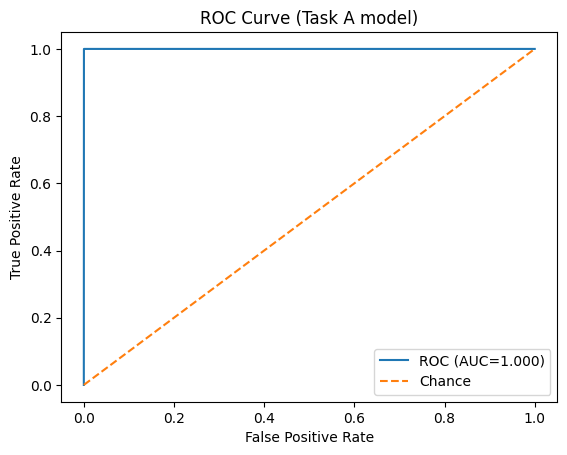

Confusion Matrix @ EER threshold [rows: TRUE (REAL,FAKE), cols: PRED (REAL,FAKE)]
[[15989     4]
 [    8 16092]]


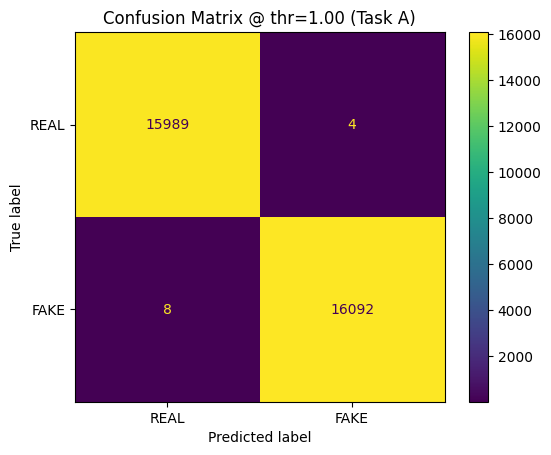

In [10]:
QUICK_MODE = False
MAX_BATCHES = 50  # only used if QUICK_MODE=True

def collect_scores_fast(m, loader, device, quick=False, max_batches=50):
    m = m.to(device).eval()
    ys, ps = [], []
    with torch.inference_mode():
        for bi, (raw, mel, y) in enumerate(loader):
            raw = raw.to(device, non_blocking=True)
            mel = mel.to(device, non_blocking=True)
            logits = m(raw, mel)
            prob_fake = torch.softmax(logits, dim=1)[:, 1]
            ys.append(y.cpu().numpy())
            ps.append(prob_fake.detach().cpu().numpy())
            if quick and (bi + 1) >= max_batches:
                break
    return np.concatenate(ys), np.concatenate(ps)

y_true, y_score = collect_scores_fast(
    model, test_loader_A, device, quick=QUICK_MODE, max_batches=MAX_BATCHES
)

auc = roc_auc_score(y_true, y_score)
fpr, tpr, thr_all = roc_curve(y_true, y_score)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fpr - fnr))
eer = 0.5 * (fpr[eer_idx] + fnr[eer_idx])
eer_thr = float(thr_all[eer_idx])

print(f"AUC = {auc:.4f}")
print(f"EER = {eer:.4f} at threshold = {eer_thr:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task A model)")
plt.legend()
plt.show()

# Confusion Matrix @ EER threshold
y_pred = (y_score >= eer_thr).astype(int)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion Matrix @ EER threshold [rows: TRUE (REAL,FAKE), cols: PRED (REAL,FAKE)]")
print(cm)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, labels=[0,1], display_labels=["REAL","FAKE"]
)
plt.title(f"Confusion Matrix @ thr={eer_thr:.2f} (Task A)")
plt.show()


In [11]:
model.load_state_dict(torch.load("fusionnet_taskA_best.pth", map_location=device))
model.eval()

report_taskA = post_training_report(model, val_loader_A, test_loader_A)

with open("taskA_report.json", "w") as f:
    json.dump(report_taskA, f, indent=2)

!ls -lh /kaggle/working | sed -n '1,200p'


{
  "model_params": 118658,
  "files": {
    "fp32_path": "fusionnet_taskA_fp32.pth",
    "fp32_mb": 0.463,
    "int8_path": "fusionnet_taskA_int8_linear.pth",
    "int8_mb": 0.301
  },
  "cpu_benchmark_fp32": {
    "batches": 1003,
    "samples": 32093,
    "total_sec": 586.107786655426,
    "sec_per_batch": 0.5843547224879622,
    "ms_per_sample": 18.262792093460444
  },
  "cpu_benchmark_int8": {
    "batches": 1003,
    "samples": 32093,
    "total_sec": 552.9961898326874,
    "sec_per_batch": 0.5513421633426594,
    "ms_per_sample": 17.23105318395561
  },
  "metrics_fp32": {
    "confusion_matrix": [
      [
        15989,
        4
      ],
      [
        4,
        16096
      ]
    ],
    "roc_auc": 0.9999685654399265,
    "eer": 0.0003735019164052246,
    "eer_threshold": 0.9985610842704773
  },
  "metrics_int8": {
    "confusion_matrix": [
      [
        15989,
        4
      ],
      [
        3,
        16097
      ]
    ],
    "roc_auc": 0.999968528544903,
    "eer": 0.0

In [12]:
def collect_scores_fast(m, loader, device, quick=False, max_batches=999999):
    m = m.to(device).eval()
    ys, ps = [], []
    with torch.inference_mode():
        for bi, (raw, mel, y) in enumerate(loader):
            raw = raw.to(device, non_blocking=True)
            mel = mel.to(device, non_blocking=True)
            p = torch.softmax(m(raw, mel), dim=1)[:, 1]
            ys.append(y.cpu().numpy()); ps.append(p.detach().cpu().numpy())
            if quick and (bi+1) >= max_batches: break
    return np.concatenate(ys), np.concatenate(ps)

def save_roc_cm_png(ckpt_path, test_loader, tag):
    m = FusionNet().to(device)
    m.load_state_dict(torch.load(ckpt_path, map_location=device))
    m.eval()

    y_true, y_score = collect_scores_fast(m, test_loader, device)
    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, thr_all = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[idx] + fnr[idx])
    thr = float(thr_all[idx])

    # ROC PNG
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--', label="Chance")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {tag}")
    plt.legend()
    plt.savefig(f"roc_{tag}.png", dpi=200, bbox_inches="tight")
    plt.close()

    # CM PNG
    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["REAL","FAKE"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {tag} @ thr={thr:.2f}")
    plt.savefig(f"cm_{tag}.png", dpi=200, bbox_inches="tight")
    plt.close()

    print(f"[{tag}] AUC={auc:.4f} | EER={eer:.4f} | thr={thr:.4f} -> saved roc_{tag}.png, cm_{tag}.png")

save_roc_cm_png("fusionnet_taskA_best.pth", test_loader_A, tag="taskA")

!ls -lh /kaggle/working | egrep "roc_|cm_"


[taskA] AUC=1.0000 | EER=0.0004 | thr=0.9986 -> saved roc_taskA.png, cm_taskA.png
-rw-r--r-- 1 root root  58K Oct 29 19:40 cm_taskA.png
-rw-r--r-- 1 root root  47K Oct 29 19:40 roc_taskA.png


In [13]:
def export_onnx_fixed(model, val_loader, out_path="fusionnet_taskA.onnx", raw_len=16000):
    model_cpu = model.to("cpu").eval()

    # infer mel shape using a real validation batch
    try:
        _, mel_b, _ = next(iter(val_loader))
        _, _, n_mels, t_frames = mel_b.shape
        n_mels = int(n_mels)
        t_frames = int(t_frames)
    except StopIteration:
        # fallback default
        n_mels, t_frames = 128, 64

    dummy_raw = torch.randn(1, 1, raw_len)
    dummy_mel = torch.randn(1, 1, n_mels, t_frames)

    torch.onnx.export(
        model_cpu,
        (dummy_raw, dummy_mel),
        out_path,
        input_names=["raw","mel"],
        output_names=["logits"],
        opset_version=17,
        do_constant_folding=True
    )
    print(f"Exported ONNX -> {out_path} | mel=({n_mels},{t_frames}) raw={raw_len}")


model_cpu = FusionNet().to("cpu")
model_cpu.load_state_dict(torch.load("fusionnet_taskA_best.pth", map_location="cpu"))
export_onnx_fixed(model_cpu, val_loader_A, out_path="fusionnet_taskA.onnx", raw_len=16000)

!ls -lh /kaggle/working/fusionnet_taskA.onnx


Exported ONNX -> fusionnet_taskA.onnx | mel=(128,63) raw=16000
-rw-r--r-- 1 root root 467K Oct 29 19:40 /kaggle/working/fusionnet_taskA.onnx


# Start TaskB here:

In [14]:
# ===== Task B dataset: telephony-style / augmented =====
# We reuse the same DeepfakeAudioDatasetTaskA class, but with use_aug=True
# so TelephonyAug is applied.

USE_AUG_TASKB = True

taskB_dataset = DeepfakeAudioDatasetTaskA(
    fake_root=FAKE_ROOT,
    real_root_main=REAL_MAIN_ROOT,
    real_root_wild=REAL_WILD_ROOT,
    real_main_cap=REAL_MAIN_CAP,
    real_wild_cap=REAL_WILD_CAP,
    sample_rate=SAMPLE_RATE,
    duration=DURATION_S,
    n_mels=N_MELS,
    use_aug=USE_AUG_TASKB
)

# same split procedure we used for Task A
indices_B = list(range(len(taskB_dataset)))
labels_B  = [taskB_dataset.labels[i] for i in indices_B]

from sklearn.model_selection import train_test_split

train_idx_B, temp_idx_B = train_test_split(
    indices_B,
    test_size=0.4,
    random_state=SEED,
    shuffle=True,
    stratify=labels_B
)

val_idx_B, test_idx_B = train_test_split(
    temp_idx_B,
    test_size=0.5,
    random_state=SEED,
    shuffle=True,
    stratify=[labels_B[i] for i in temp_idx_B]
)

from torch.utils.data import Subset, DataLoader

train_set_B = Subset(taskB_dataset, train_idx_B)
val_set_B   = Subset(taskB_dataset, val_idx_B)
test_set_B  = Subset(taskB_dataset, test_idx_B)

train_loader_B = DataLoader(train_set_B, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_B   = DataLoader(val_set_B,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_B  = DataLoader(test_set_B,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Task B split sizes:", len(train_set_B), len(val_set_B), len(test_set_B))


[TaskA Dataset] fake=80500 real=79963 total=160463
Task B split sizes: 96277 32093 32093


In [15]:
# Load Task A model as the starting point for Task B
model_B = FusionNet().to(device)
model_B.load_state_dict(torch.load("fusionnet_taskA_best.pth", map_location=device))
model_B.train()

# Take a snapshot of the original weights for regularization
prev_weights = {}
for name, p in model_B.named_parameters():
    prev_weights[name] = p.detach().clone()

print("Loaded Task A weights into model_B and snapshotted prev_weights.")


Loaded Task A weights into model_B and snapshotted prev_weights.


In [16]:
# Freeze backbone to protect learned audio features
for p in model_B.spec_model.parameters():
    p.requires_grad = False
for p in model_B.raw_model.parameters():
    p.requires_grad = False

# Classifier stays trainable
for p in model_B.classifier.parameters():
    p.requires_grad = True


In [17]:
def continual_train_taskB(
    model,
    train_loader_new,
    val_loader_old,
    prev_weights_dict,
    device,
    epochs=8,
    lr=5e-4,
    reg_lambda=1e-3,
    clip_norm=1.0,
    patience=3,
    save_path="fusionnet_taskB_best.pth"
):
    """
    train_loader_new: Task B data (telephony augmented)
    val_loader_old:   Task A validation loader (clean data!)
                      we validate on OLD domain to watch forgetting.
    prev_weights_dict: snapshot of Task A weights for stability regularization
    """

    opt = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=1e-4
    )
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.5, patience=1
    )
    loss_fn = torch.nn.CrossEntropyLoss()

    scaler = torch.amp.GradScaler("cuda", enabled=torch.cuda.is_available())

    best_val_loss = float("inf")
    no_improve = 0

    for epoch in range(1, epochs+1):
        model.train()
        run_loss = 0.0
        run_correct = 0
        seen = 0

        for raw, mel, labels in train_loader_new:
            raw, mel, labels = raw.to(device), mel.to(device), labels.to(device)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
                out = model(raw, mel)
                base_loss = loss_fn(out, labels)

                # regularization term: don't drift too far from Task A weights
                reg_loss = 0.0
                for (name, p) in model.named_parameters():
                    if p.requires_grad and name in prev_weights_dict:
                        reg_loss = reg_loss + (p - prev_weights_dict[name].to(device)).pow(2).mean()

                loss = base_loss + reg_lambda * reg_loss

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            scaler.step(opt)
            scaler.update()

            run_loss += loss.item() * labels.size(0)
            run_correct += (out.argmax(1) == labels).sum().item()
            seen += labels.size(0)

        train_loss = run_loss / seen
        train_acc  = run_correct / seen

        # validate on OLD domain (Task A val set) to measure forgetting
        val_loss, val_acc = evaluate(model, val_loader_old, device)

        sched.step(val_loss)

        print(f"[TaskB] Epoch {epoch:02d} | train {train_loss:.4f}/{train_acc:.4f} "
              f"| old_val {val_loss:.4f}/{val_acc:.4f}")

        # early stopping on OLD domain val loss -> we try not to destroy Task A
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            no_improve = 0
            torch.save(model.state_dict(), save_path)
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping Task B.")
                break

    print("Best continual checkpoint saved to:", save_path)


In [18]:
# Fine-tune model_B on Task B data for continual learning
continual_train_taskB(
    model=model_B,
    train_loader_new=train_loader_B,
    val_loader_old=val_loader_A,          # <-- IMPORTANT: validate on Task A val
    prev_weights_dict=prev_weights,
    device=device,
    epochs=8,
    lr=5e-4,
    reg_lambda=1e-3,
    save_path="fusionnet_taskB_best.pth"
)


[TaskB] Epoch 01 | train 1.4273/0.7934 | old_val 0.3669/0.9017
[TaskB] Epoch 02 | train 0.3504/0.8395 | old_val 0.1871/0.9322
[TaskB] Epoch 03 | train 0.3331/0.8496 | old_val 0.1802/0.9362
[TaskB] Epoch 04 | train 0.3260/0.8539 | old_val 0.1554/0.9558
[TaskB] Epoch 05 | train 0.3194/0.8575 | old_val 0.1775/0.9536
[TaskB] Epoch 06 | train 0.3104/0.8616 | old_val 0.2669/0.9382
[TaskB] Epoch 07 | train 0.3038/0.8634 | old_val 0.3832/0.9133
Early stopping Task B.
Best continual checkpoint saved to: fusionnet_taskB_best.pth


In [19]:
# Load best continual model
modelB_eval = FusionNet().to(device)
modelB_eval.load_state_dict(torch.load("fusionnet_taskB_best.pth", map_location=device))
modelB_eval.eval()

# 1. How well does it do on NEW domain (telephony)?
loss_B_new, acc_B_new = evaluate(modelB_eval, test_loader_B, device)
print(f"[TaskB model on TaskB audio] loss={loss_B_new:.4f} acc={acc_B_new:.4f}")

# 2. How well does it REMEMBER OLD domain (clean)?
loss_B_old, acc_B_old = evaluate(modelB_eval, test_loader_A, device)
print(f"[TaskB model on TaskA audio] loss={loss_B_old:.4f} acc={acc_B_old:.4f}")


[TaskB model on TaskB audio] loss=0.2873 acc=0.8734
[TaskB model on TaskA audio] loss=0.1445 acc=0.9589


In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# we'll reuse device, FusionNet, test_loader_B from earlier

def collect_scores_for_loader(model, loader, device):
    model = model.to(device).eval()
    ys, ps = [], []
    with torch.no_grad():
        for raw, mel, y in loader:
            raw = raw.to(device, non_blocking=True)
            mel = mel.to(device, non_blocking=True)

            logits = model(raw, mel)
            prob_fake = torch.softmax(logits, dim=1)[:, 1]  # P(class=FAKE)

            ys.append(y.cpu().numpy())
            ps.append(prob_fake.detach().cpu().numpy())

    y_true = np.concatenate(ys)
    y_score = np.concatenate(ps)
    return y_true, y_score

def save_taskB_roc_cm(taskB_ckpt_path, test_loader_new, tag="taskB"):
    # 1. load continual model
    m = FusionNet().to(device)
    m.load_state_dict(torch.load(taskB_ckpt_path, map_location=device))
    m.eval()

    # 2. collect scores on Task B domain (telephony)
    y_true, y_score = collect_scores_for_loader(m, test_loader_new, device)

    # 3. metrics
    auc = roc_auc_score(y_true, y_score)

    fpr, tpr, thr_all = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[idx] + fnr[idx])
    thr = float(thr_all[idx])

    print(f"[{tag}] AUC={auc:.4f} | EER={eer:.4f} | thr={thr:.4f}")

    # 4. ROC plot
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--', label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {tag} (continual model)")
    plt.legend()
    plt.savefig(f"roc_{tag}.png", dpi=200, bbox_inches="tight")
    plt.close()

    # 5. Confusion matrix @ EER threshold
    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    disp = ConfusionMatrixDisplay(cm, display_labels=["REAL","FAKE"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {tag} @ thr={thr:.2f}")
    plt.savefig(f"cm_{tag}.png", dpi=200, bbox_inches="tight")
    plt.close()

    print(f"Saved roc_{tag}.png and cm_{tag}.png")
    print("Confusion matrix:\n", cm)

# run it for Task B
save_taskB_roc_cm(
    taskB_ckpt_path="fusionnet_taskB_best.pth",
    test_loader_new=test_loader_B,
    tag="taskB"
)

# show files
!ls -lh /kaggle/working | egrep "roc_|cm_"


[taskB] AUC=0.9493 | EER=0.1291 | thr=0.4949
Saved roc_taskB.png and cm_taskB.png
Confusion matrix:
 [[13928  2065]
 [ 2079 14021]]
-rw-r--r-- 1 root root  58K Oct 29 19:40 cm_taskA.png
-rw-r--r-- 1 root root  56K Oct 29 21:35 cm_taskB.png
-rw-r--r-- 1 root root  47K Oct 29 19:40 roc_taskA.png
-rw-r--r-- 1 root root  69K Oct 29 21:35 roc_taskB.png


In [21]:
import torch
import torchaudio

def export_taskB_to_onnx(taskB_ckpt_path, val_loader_for_shape, out_path="fusionnet_taskB.onnx", raw_len=16000):
    # rebuild model and load weights
    model_cpu = FusionNet().to("cpu")
    model_cpu.load_state_dict(torch.load(taskB_ckpt_path, map_location="cpu"))
    model_cpu.eval()

    # infer mel shape using a real batch from Task B val loader (telephony domain)
    try:
        _, mel_b, _ = next(iter(val_loader_for_shape))
        _, _, n_mels, t_frames = mel_b.shape
        n_mels = int(n_mels)
        t_frames = int(t_frames)
    except StopIteration:
        # backup in case loader was empty
        n_mels, t_frames = 128, 64

    # dummy inputs to trace ONNX
    dummy_raw = torch.randn(1, 1, raw_len)
    dummy_mel = torch.randn(1, 1, n_mels, t_frames)

    torch.onnx.export(
        model_cpu,
        (dummy_raw, dummy_mel),
        out_path,
        input_names=["raw","mel"],
        output_names=["logits"],
        opset_version=17,
        do_constant_folding=True
    )

    print(f"Exported ONNX -> {out_path} | mel=({n_mels},{t_frames}) raw={raw_len}")

# export the Task B model using Task B val loader (so shapes match Task B preprocessing)
export_taskB_to_onnx(
    taskB_ckpt_path="fusionnet_taskB_best.pth",
    val_loader_for_shape=val_loader_B,
    out_path="fusionnet_taskB.onnx",
    raw_len=16000
)

!ls -lh /kaggle/working/fusionnet_taskB.onnx


Exported ONNX -> fusionnet_taskB.onnx | mel=(128,63) raw=16000
-rw-r--r-- 1 root root 467K Oct 29 21:35 /kaggle/working/fusionnet_taskB.onnx


# **TEST ON ONNX FILE STARTS#  FROM HERE******# # 

In [22]:
!pip -q install onnxruntime scikit-learn torchaudio

import os, csv, math, json, time, pathlib, random
from typing import List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchaudio
import onnxruntime as ort

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 932.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.5 MB/s eta 0:00:00


In [23]:
ONNX_PATH = "/kaggle/input/fusionnet-taskb-onnx/onnx/default/1/fusionnet_taskB.onnx"
DATA_ROOT = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing"
MANIFEST_CSV = ""  

In [24]:
import os, glob, pathlib
assert os.path.exists(ONNX_PATH), f"ONNX not found: {ONNX_PATH}"
assert os.path.isdir(DATA_ROOT), f"DATA_ROOT missing: {DATA_ROOT}"

print("ONNX ok:", ONNX_PATH)
print("AUDIO root:", DATA_ROOT)
print("FAKE count:", len(glob.glob(os.path.join(DATA_ROOT, "fake", "*"))))
print("REAL count:", len(glob.glob(os.path.join(DATA_ROOT, "real", "*"))))

# (Optional) show one example from each class
for sub in ["real","fake"]:
    some = glob.glob(os.path.join(DATA_ROOT, sub, "*"))[:1]
    print(sub, "example:", some[0] if some else "—")


ONNX ok: /kaggle/input/fusionnet-taskb-onnx/onnx/default/1/fusionnet_taskB.onnx
AUDIO root: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing
FAKE count: 2370
REAL count: 2264
real example: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real/file508.wav_16k.wav_norm.wav_mono.wav_silence.wav
fake example: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/fake/file508.wav_16k.wav_norm.wav_mono.wav_silence.wav


In [25]:
SAMPLE_RATE = 16000
DURATION_S  = 1.0
N_MELS      = 128
N_FFT       = 1024
HOP         = 256
#BATCH_SIZE  = max
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

MAX_LEN = int(SAMPLE_RATE * DURATION_S)

melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_mels=N_MELS,
    n_fft=N_FFT,
    hop_length=HOP,
    power=2.0,
)
to_db = torchaudio.transforms.AmplitudeToDB(stype="power")

def load_resample_mono_crop1s(path: str) -> torch.Tensor:
    wav, sr = torchaudio.load(path)  # (C, N)
    wav = wav.mean(dim=0)
    if sr != SAMPLE_RATE:
        wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)
    if wav.shape[0] < MAX_LEN:
        wav = torch.nn.functional.pad(wav, (0, MAX_LEN - wav.shape[0]))
    else:
        wav = wav[:MAX_LEN]
    return wav

def wav_to_features_1s(wav_1d: torch.Tensor):
    raw = wav_1d.unsqueeze(0).unsqueeze(0).float()      # (1,1,L)
    mel = to_db(melspec(raw)).float()                   # (1,1,N_MELS,T)
    return raw, mel

def softmax_np(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / (np.sum(e, axis=1, keepdims=True) + 1e-12)


In [26]:
def find_audio_files(root: str, exts=(".wav", ".flac", ".mp3")) -> List[str]:
    out = []
    for r, _, fs in os.walk(root):
        for f in fs:
            if f.lower().endswith(exts):
                out.append(os.path.join(r, f))
    return out

def load_manifest(csv_path: str) -> Tuple[List[str], Optional[List[int]]]:
    paths, labels = [], []
    with open(csv_path, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            p = row["path"]
            lbl = row.get("label", "")
            paths.append(p)
            if lbl == "":
                labels = None
            else:
                labels.append(int(lbl))
    if labels is None or len(labels) == 0:
        labels = None
    return paths, labels

def load_from_folder(root: str) -> Tuple[List[str], Optional[List[int]]]:
    all_files = find_audio_files(root)
    if not all_files:
        return [], None

    paths, labels = [], []
    has_any_label = False
    for p in all_files:
        parent = pathlib.Path(p).parent.name.lower()
        if "real" in parent:
            paths.append(p); labels.append(0); has_any_label = True
        elif "fake" in parent:
            paths.append(p); labels.append(1); has_any_label = True
        else:
            paths.append(p); labels.append(None)

    if not has_any_label:
        return paths, None
    else:
        if any(l is None for l in labels):
            return paths, None
        return paths, labels

if MANIFEST_CSV:
    ext_paths, ext_labels = load_manifest(MANIFEST_CSV)
else:
    ext_paths, ext_labels = load_from_folder(DATA_ROOT) if DATA_ROOT else ([], None)

print(f"[External Data] files={len(ext_paths)} | labels={'yes' if ext_labels is not None else 'no'}")
assert len(ext_paths) > 0, "No external files found. Set DATA_ROOT or MANIFEST_CSV correctly."



[External Data] files=4634 | labels=yes


In [27]:
import os, pathlib, numpy as np

print("Total files discovered:", len(ext_paths))

def infer_label_from_path(p: str):
    low = p.lower().replace("\\", "/")
    # Look anywhere in the path, not just parent folder
    if "/real/" in low or low.split("/")[-2].startswith("real"):
        return 0
    if "/fake/" in low or low.split("/")[-2].startswith("fake"):
        return 1
    return None

ext_labels_aligned = [infer_label_from_path(p) for p in ext_paths]
num_labeled = sum(l is not None for l in ext_labels_aligned)
print(f"Labeled files: {num_labeled}/{len(ext_paths)}")

if num_labeled == len(ext_paths):
    have_lbls = True
    labels_np = np.array(ext_labels_aligned, dtype=np.int64)
else:
    have_lbls = False
    labels_np = None
    print("Mixed or missing labels detected — proceeding in UNLABELED mode (no ROC/CM).")

Total files discovered: 4634
Labeled files: 4634/4634


Input meta: {'raw': [1, 1, 16000], 'mel': [1, 1, 128, 63]}
[ONNX External] Scored 4634 samples in 90.66s (19.56 ms/sample)
Saved: predictions_TaskBTestedOnONNXForRData.csv
AUC = 0.1923
EER = 0.7410 @ thr=0.1200


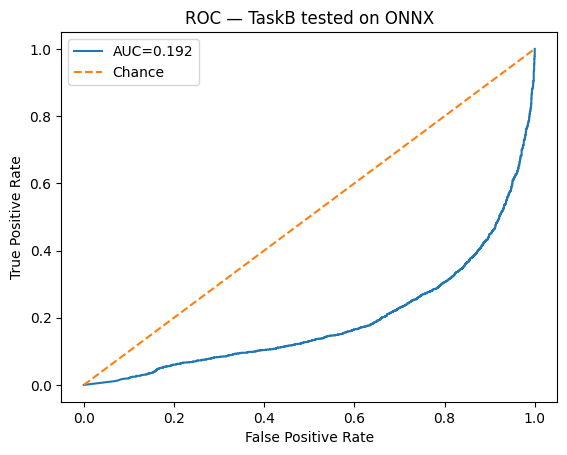

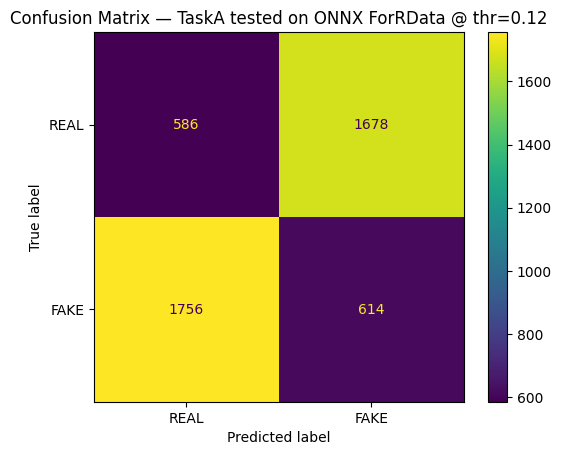

-rw-r--r-- 1 root root  309 Oct 29 21:38 TaskBTestedOnONNXForRData_report.json


In [28]:
assert os.path.exists(ONNX_PATH), f"ONNX not found at {ONNX_PATH}"
so = ort.SessionOptions()
so.intra_op_num_threads = 1
so.inter_op_num_threads = 1
sess = ort.InferenceSession(ONNX_PATH, sess_options=so, providers=["CPUExecutionProvider"])

RAW_NAME = "raw"; MEL_NAME = "mel"
inp_meta = {i.name: i.shape for i in sess.get_inputs()}
print("Input meta:", inp_meta)

def run_onnx_single(raw_np_1, mel_np_1):
    return sess.run(None, {RAW_NAME: raw_np_1.astype("float32"),
                           MEL_NAME: mel_np_1.astype("float32")})[0]  # (1,2)

scores = np.zeros(len(ext_paths), dtype=np.float32)  # P(fake)
preds  = np.zeros(len(ext_paths), dtype=np.int64)

n = 0
t0 = time.time()

for i, pth in enumerate(ext_paths):
    try:
        wav = load_resample_mono_crop1s(pth)
        raw, mel = wav_to_features_1s(wav)                 
        logits = run_onnx_single(raw.numpy(), mel.numpy()) 
        z = logits - logits.max(axis=1, keepdims=True)
        prob_fake = (np.exp(z) / (np.exp(z).sum(axis=1, keepdims=True)+1e-12))[0,1]
        scores[i] = prob_fake
        preds[i]  = int(prob_fake >= 0.5)
        n += 1
    except Exception:
        pass

dt = time.time() - t0
print(f"[ONNX External] Scored {n} samples in {dt:.2f}s ({1000.0*dt/max(1,n):.2f} ms/sample)")

# Save predictions CSV
out_rows = [["path", "p_fake", "pred", "label"]]
for i, pth in enumerate(ext_paths):
    lbl = "" if not have_lbls else int(labels_np[i])
    out_rows.append([pth, float(scores[i]), int(preds[i]), lbl])

with open("predictions_TaskBTestedOnONNX_ForRData.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(out_rows)

print("Saved: predictions_TaskBTestedOnONNXForRData.csv")

if have_lbls:
    # ROC-AUC / EER
    try:
        auc = roc_auc_score(labels_np, scores)
    except ValueError:
        auc = float("nan")
    fpr, tpr, thr = roc_curve(labels_np, scores)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[idx] + fnr[idx])
    eer_thr = float(thr[idx])
    print(f"AUC = {auc:.4f}")
    print(f"EER = {eer:.4f} @ thr={eer_thr:.4f}")

    # ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],"--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC — TaskB tested on ONNX")
    plt.legend()
    plt.savefig("roc_TaskB tested on ONNXForRData.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Confusion matrix at EER threshold
    y_pred_eer = (scores >= eer_thr).astype(int)
    cm = confusion_matrix(labels_np, y_pred_eer, labels=[0,1])

    disp = ConfusionMatrixDisplay(cm, display_labels=["REAL","FAKE"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — TaskA tested on ONNX ForRData @ thr={eer_thr:.2f}")
    plt.savefig("cm_TaskB tested on ONNXForRData.png", dpi=200, bbox_inches="tight")
    plt.show()

    report = {
        "onnx_path": ONNX_PATH,
        "num_samples": int(len(ext_paths)),
        "auc": float(auc),
        "eer": float(eer),
        "eer_threshold": float(eer_thr),
        "confusion_matrix": cm.tolist()
    }
    with open("TaskBTestedOnONNXForRData_report.json", "w") as f:
        json.dump(report, f, indent=2)

    !ls -lh | egrep "predictions_TaskBTestedOnONNXForRData|roc_TaskBTestedOnONNXForRData|cm_TaskBTestedOnONNXForRData|TaskBTestedOnONNXForRData_report"
else:
    print("No labels detected — skipped ROC/CM. Only predictions_external.csv was created.")
    !ls -lh predictions_external.csv

In [29]:
!rm -f "cm_TaskB tested on ONNX.png" \
      cm_external.png \
      external_report.json \
      predictions_external.csv \
      "roc_TaskB tested on ONNX.png" \
      roc_external.png